In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table

import sys
sys.path.append('../')
sys.path.append('../../')

import WD_models
from stark import measure, analyze, plotting, utils

In [40]:
window = 8
line = 'abgd'

In [55]:
def rv_from_logg(loggarray, teffarray, Hlayer = 'H'):
    mass_sun = 1.9884e30
    radius_sun = 6.957e8
    newton_G = 6.674e-11
    pc_to_m = 3.086775e16
    speed_light = 299792458 #m/s

    font_model = WD_models.load_model('f', 'f', 'f', Hlayer)
    g_acc = (10**font_model['logg'])/100
    rsun = np.sqrt(font_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
    logg_teff_to_r = WD_models.interp_xy_z_func(x = font_model['logg'], y = 10**font_model['logteff'],\
                                                z = rsun, interp_type = 'linear')
    
    radius = logg_teff_to_r(loggarray, teffarray) * radius_sun
    rv = (10**loggarray * radius) / (100 * speed_light)
    return rv*1e-3

sdsssample = pd.read_csv('../data/raw/sdss_commonpm.csv').query("snr > 15 and R_chance_align < 0.1").drop(columns=['wd_rv', 'wd_e_rv', 'wd_redchi', 'vgtheoretical', 'vgobs', 'e_vgobs'])
sdsssample = sdsssample.dropna(subset=['TeffH', 'loggH'])
sdsssample['gravz_H'] = rv_from_logg(sdsssample.loggH, sdsssample.TeffH, Hlayer='H')

dat = pd.read_csv(f"{utils.fetch_basepath()}/data/sdss/1d_da_nlte/{line}/window_{window}.csv").query("wd_redchi < 10 and 7.1 < wd_logg < 8.9 and wd_e_rv < 10")
sdsssample = pd.merge(sdsssample, dat, on='wd_source_id')

#sdsssample.dropna(inplace=True)
sdsssample['vgobs'] = sdsssample['wd_rv'] - sdsssample['ms_rv']
sdsssample['e_vgobs'] = np.sqrt(sdsssample['wd_e_rv']**2 + sdsssample['ms_e_rv']**2)

#sigma_to_clip = 3
#mean = np.mean(sdsssample.vgobs)
#stddev = np.std(sdsssample.vgobs)
#sdsssample = sdsssample.query(f"abs(vgobs - {mean}) < {sigma_to_clip * stddev}")
sdsssample['vstark'] = sdsssample['vgobs'] - sdsssample['gravz_H']
sdsssample['e_vstark'] = sdsssample['e_vgobs']

sdss4 = sdsssample.query("wd_rv_from != 'sdss5'").copy()
sdss5 = sdsssample.query("wd_rv_from != 'sdss4'").copy()

In [58]:
len(sdss4), len(sdss5)

(59, 19)

In [66]:
sdssteffdata, sdssloggdata = analyze.calculate_parameter_bins(dataframe=sdss5, teffcol='TeffH', loggcol='loggH', n=5)
sdssalldata = (sdss5.TeffH.values, sdss5.vstark.values, sdss5.e_vstark.values)
#plotting.parameter_stark_plot(sdssalldata, paramdata=sdssteffdata, plot_zzceti=False, xlims=(4000, 30000), ylims=(-100, 100))

(-50.0, 50.0)

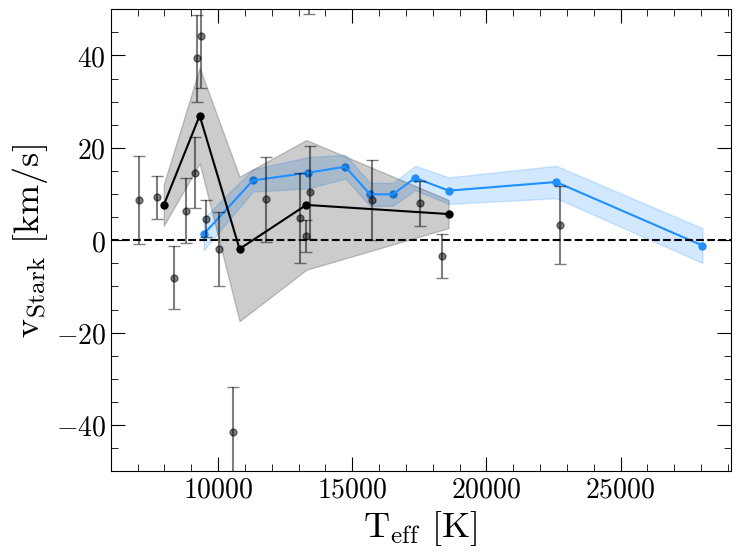

In [65]:
lteargs = {'model' : '1d_da_nlte', 'lines' : line, 'window' : window}
spystarkdf = utils.read_stark_effect(lteargs, sigmaclip=True)
spyteffdata, spyloggdata = analyze.calculate_parameter_bins(dataframe=spystarkdf, teffcol='TeffH', loggcol='loggH', n=10)
spyalldata = (spystarkdf.TeffH.values, spystarkdf.vstark.values, spystarkdf.e_vstark.values)

# begin plotting
fig, ax = plt.subplots(ncols = 1, figsize=(8,6))
plotting.plot_with_shaded_error(ax, spyteffdata[0], spyteffdata[1], yerr=spyteffdata[2], 
                                plot_kwargs={'color' : 'dodgerblue'}, 
                                scatter_kwargs={'label' : 'data', 'color' : 'dodgerblue', 'marker' : 'o'}, 
                                fill_kwargs={'color' : 'dodgerblue', 'alpha' : 0.2})
plotting.plot_with_shaded_error(ax, sdssteffdata[0], sdssteffdata[1], yerr=sdssteffdata[2], 
                                plot_kwargs={'color' : 'k'}, 
                                scatter_kwargs={'label' : 'data', 'color' : 'k', 'marker' : 'o'}, 
                                fill_kwargs={'color' : 'k', 'alpha' : 0.2})
ax.errorbar(sdss5.TeffH.values, sdss5.vstark.values, yerr=sdss5.e_vstark.values, c = 'k', capsize=4, fmt='o', alpha=0.5)
ax.axhline(y=0, c='k', ls = '--')
ax.set_ylabel(r'$v_{Stark}$ $[km/s]$')
ax.set_xlabel(r'$T_\text{eff}$ $[K]$')
ax.set_ylim(4000, 30000)
ax.set_ylim(-50, 50)